<a href="https://colab.research.google.com/github/Agrover112/SiameseNet-Search/blob/main/Siamese_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random



print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("X_train:",x_train.shape,"Y_train:",y_train.shape,"X_test:",x_test.shape,"Y_test:",y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28) Y_train: (60000,) X_test: (10000, 28, 28) Y_test: (10000,)


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape,x_test.shape)

(60000, 784) (10000, 784)


In [ ]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

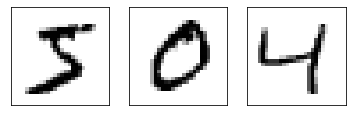

In [ ]:

plot_triplets([x_train[0], x_train[1], x_train[2]])

In [ ]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))  #single d( Find and remove)
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

(1, 784)


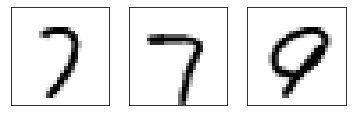

In [ ]:
examples = create_batch(1)
print(examples[2].shape)
plot_triplets(examples)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
emb_size = 64

embedding_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])


In [ ]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
img= np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(img)[0]

print("Embedding is:",example_emb)

Embedding is: [0.5558166  0.4789469  0.5317682  0.5817168  0.5125536  0.52936715
 0.44506085 0.41482466 0.4883641  0.5178479  0.48641148 0.46334848
 0.56566983 0.50364685 0.58933526 0.5548806  0.5400239  0.5068117
 0.50458384 0.5324708  0.5325529  0.5761824  0.44169062 0.55862546
 0.45468074 0.6136361  0.39155254 0.55574286 0.58217895 0.45600674
 0.57752913 0.6132797  0.42865747 0.38268888 0.49420983 0.38850552
 0.42166543 0.4359734  0.5522154  0.54921347 0.523246   0.47620258
 0.3711207  0.4876512  0.5719194  0.5678689  0.5033949  0.549955
 0.4693066  0.4094522  0.44309568 0.49248514 0.5982806  0.50349045
 0.34433186 0.48971647 0.50057507 0.63986444 0.52874315 0.5199904
 0.5430845  0.45710063 0.56601626 0.52948743]


Creation of the Siamese Network starts here

In [ ]:
    input_anchor = tf.keras.layers.Input(shape=(784,))
    input_positive = tf.keras.layers.Input(shape=(784,))
    input_negative = tf.keras.layers.Input(shape=(784,))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1) #Concat alll embeddings 

    siamnet = tf.keras.models.Model([input_anchor, input_positive, input_negative], output) 
    siamnet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_4[0][0]                    
                                                                 input_5[0][0]         

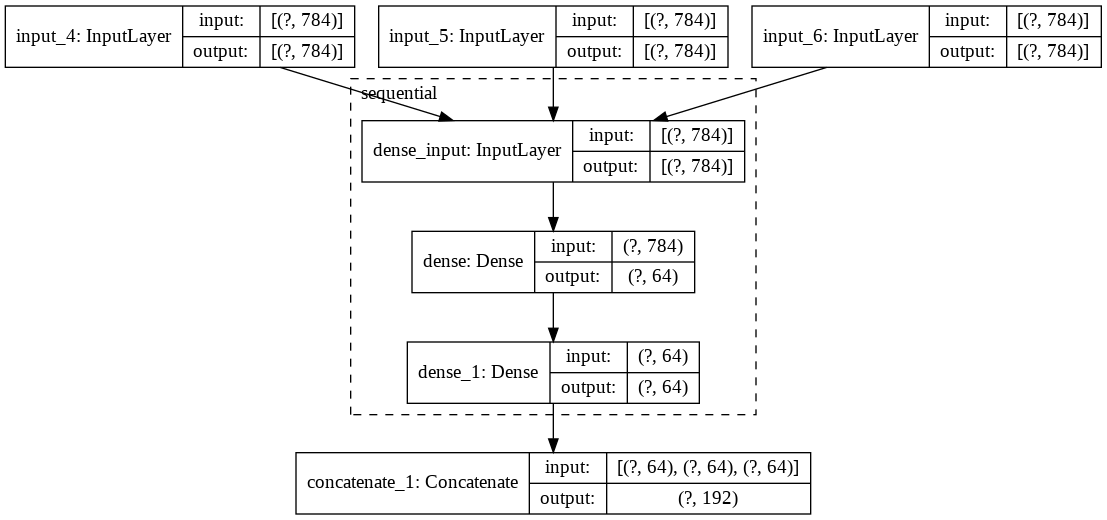

In [ ]:
tf.keras.utils.plot_model(siamnet,show_shapes=True,show_layer_names=True,expand_nested=True)

In [ ]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [ ]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)


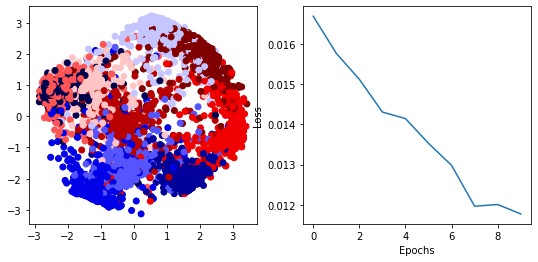

In [ ]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)   # 60K/2048 =~30 steps per epoch

siamnet.compile(loss=triplet_loss, optimizer='adam')

_= siamnet.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:10000], y_test[:10000]
        )]
)

In [ ]:
embedding_model.save('embedding_model.h5')

In [ ]:
siamnet.layers[3].layers[1].get_weights()[1].shape

(64,)

In [ ]:
siamnet.layers[3].get_weights()[3].shape

(64,)

In [ ]:
siamnet.save_weights('siamnet_weights.h5')

In [ ]:
embedding_model.layers[1].get_weights()[1].shape

(64,)

In [ ]:
siamnet.load_weights('siamnet_weights.h5')

In [ ]:
siamnet.layers[3].layers[1].get_weights()[1].shape

(64,)

In [ ]:
    input_1 = tf.keras.layers.Input(shape=(784,))
    input_2 = tf.keras.layers.Input(shape=(784,))
    